In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import os

from functions.utils import state_dict_to_vector

from model.models_kde import TracksToKDE_Ellipsoids_DDplus as Model
from model.kde_loss_Ba import Loss
from model.collectdata_kde_Ellipsoids import collect_t2kde_data
device = 'cuda:2'

In [2]:
#dict with run_title : (num_events (in thousands), list of (num_epochs, dir_name))
all_runs = {
    'Adam':(160,
                      [(30, 'Sep14_160k_Adam'),
                       (30, 'Sep14_160k_Adam_iter1')]),
    'Adam_lowerlr':(160,
                      [(30, 'Sep14_160k_Adam_lowerlr'),
                       (30, 'Sep14_160k_Adam_lowerlr_iter1')
                      ]),
    'Adam EVE':(160,
                      [(60, 'Sep14_160k_Adam_EVE_lowerlr')]),
    'carefulAdam 5%':(160,
                      [(30, 'Sep14_160k_carefulAdam'),
                       #(30, 'Sep14_160k_carefulAdam_iter1')
                      ]), 
    'carefulAdam 2%':(160,
                      [(60, 'Sep14_160k_carefulAdam2%')]),
    'morecarefulAdam 5%':(160,
                      [(30, 'Sep14_160k_morecarefulAdam'),
                       (30, 'Sep14_160k_morecarefulAdam_iter1')
                      ]),
    'morecarefulAdam 2%':(160,
                      [(60, 'Sep14_160k_morecarefulAdam2%')]),
    'epochstepAdam':(160,
                      [(60, 'Sep14_160k_epstepAdam_lowerlr_correct')]), 
    'adaptiveAdam':(160,
                      [(30, 'Sep14_160k_adaptiveAdam'),
                       (17, 'Sep14_160k_adaptiveAdam_iter1')]),
    'adaptiveAdam_careful 2%':(160,
                      [(30, 'Sep14_160k_adaptivecarefulAdam')]),
    'adaptiveAdam_careful losslim2% inc2%':(160,
                      [(60, 'Sep14_160k_adaptivecarefulAdam_inc2%')]),
    'adaptiveAdam_morecareful 2%':(160,
                      [(30, 'Sep14_160k_adaptivemorecarefulAdam')]),
    'adaptiveAdam_careful 5%':(160,
                               [(34, 'Sep14_160k_adaptivecarefulAdam5%')]),
    'adaptiveAdam_morecareful 5%':(160,
                               [(31, 'Sep14_160k_adaptivemorecarefulAdam5%')])
    
    }

#to quickly call runs via number
run_names = {}
for i,key in enumerate(list(all_runs)):
    print(i, ':', key)
    run_names[i] = key

0 : Adam
1 : Adam_lowerlr
2 : Adam EVE
3 : carefulAdam 5%
4 : carefulAdam 2%
5 : morecarefulAdam 5%
6 : morecarefulAdam 2%
7 : epochstepAdam
8 : adaptiveAdam
9 : adaptiveAdam_careful 2%
10 : adaptiveAdam_careful losslim2% inc2%
11 : adaptiveAdam_morecareful 2%
12 : adaptiveAdam_careful 5%
13 : adaptiveAdam_morecareful 5%


In [3]:
#Select runs to plot
runs = [0, 1, 2, 4, 5, 7, 10]
#[i for i in range(len(all_runs))]

run_labels = [run_names[i] for i in runs]

#now to generate list of paths to the stored model dicts
dict_paths = []
num_epochs = []
for run_label in run_labels:
    these_paths = []
    this_num_epochs = 0
    dir_tuples = all_runs[run_label][1]
    for dir_tuple in dir_tuples:
        
        this_num_epochs += dir_tuple[0]
        dir_name = dir_tuple[1]
        for j in range(dir_tuple[0]):
            #print('ML/' + dir_names[i] + '/' + dir_names[i] + '_%i.pyt'%(j))
            these_paths.append('baileyds/DDplus/' + dir_name + '/' + dir_name + '_%i.pyt'%(j))
    dict_paths.append(these_paths)
    num_epochs.append(this_num_epochs)
    
eval_losses = []

scan_sizes = {18:20, 80:5, 160:3, 320:1}

In [4]:
for paths in dict_paths:
    for filepath in paths:
        assert os.path.exists(filepath) == True

In [5]:
# val_data = collect_t2kde_data('/share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5',
#                             batch_size=64,
#                             device=device,
#                             #slice = slice(19000,None)
#                            )

In [6]:
nOut1 = 50
nOut2 = 50
nOut3 = 50
nOut4 = 50
nOut5 = 50
nOut6 = 50
nOut7 = 50
nOut8 = 50
nOut9 = 50
nOut10 = 50
nOut11 = 50
latentChannels = 4
model = Model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)
model.to(device)
loss_fn = Loss(epsilon=3e-5)

In [7]:
def train_loss(dataloader, model, loss_fn):
    model.train()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    return test_loss/len(dataloader)

def eval_loss(dataloader, model, loss_fn):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    return test_loss/len(dataloader)

In [8]:
# for i,paths in enumerate(dict_paths):
#     print('On run:', run_labels[i])
#     these_train_losses = []
#     these_eval_losses = []
#     scan_size = scan_sizes[all_runs[run_labels[i]][0]]
#     print(f'{all_runs[run_labels[i]][0]}k events -> scan size = {scan_size}')
#     for ep in np.arange(0, num_epochs[i], scan_size):
#         print("Epoch:", ep, '/', num_epochs[i])
#         state_dict = torch.load(paths[ep], map_location=device)
#         model.load_state_dict(state_dict)
# #         start_time = time.time()
# #         these_train_losses.append(train_loss(train_data, model, loss_fn))
# #         print("Train loss time:", time.time()-start_time)
#         start_time = time.time()
#         these_eval_losses.append(eval_loss(val_data, model, loss_fn))
#         print("Eval loss time:", time.time()-start_time)
#         print('#############################################')
#     #eval_losses.append(these_eval_losses)
#     #add the last values if not added
#     if ep != (len(paths)-1):
#         ep = (len(paths)-1)
#         print("Epoch:", ep, '/', num_epochs[i])
#         state_dict = torch.load(paths[ep], map_location=device)
#         model.load_state_dict(state_dict)
# #         start_time = time.time()
# #         these_train_losses.append(train_loss(train_data, model, loss_fn))
# #         print("Train loss time:", time.time()-start_time)
#         start_time = time.time()
#         these_eval_losses.append(eval_loss(val_data, model, loss_fn))
#         print("Eval loss time:", time.time()-start_time)
#         print('#############################################')
#     eval_losses.append(these_eval_losses)
    
# with open('Sep14_runs_savedloss.txt', 'w') as f:
#     for i in range(len(dict_paths)):
#         print(i)
#         this_loss = eval_losses[i]
#         for j in range(len(this_loss)):
#             f.write(str(this_loss[j]))
#             if j+1 in range(len(this_loss)):
#                 f.write(',')
#         if i+1 in range(len(dict_paths)):
#             f.write('\n')

In [9]:
eval_losses = []
with open('Sep14_runs_savedloss.txt', 'r') as f:
    idx = 0
    for line in f:
        if idx in runs:
            eval_losses.append([float(val) for val in line.split(',')])
        idx += 1

<IPython.core.display.Javascript object>


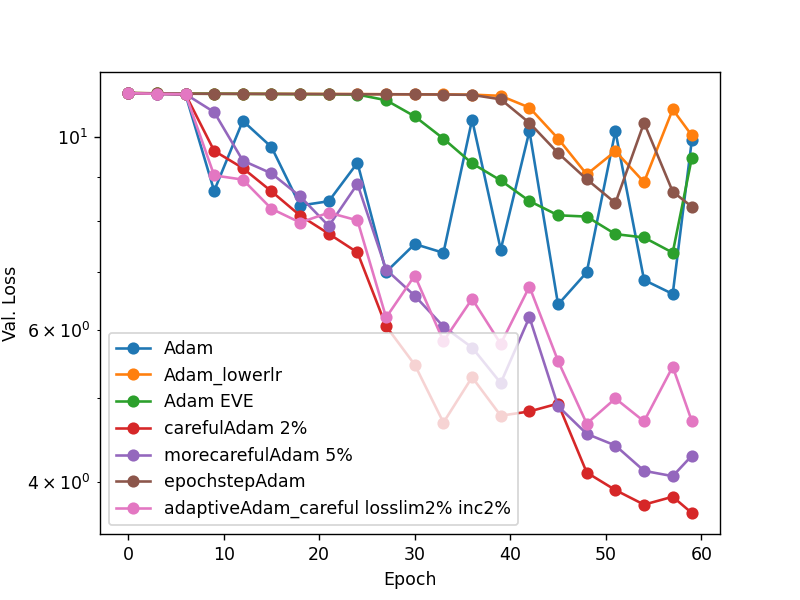

<IPython.core.display.Javascript object>


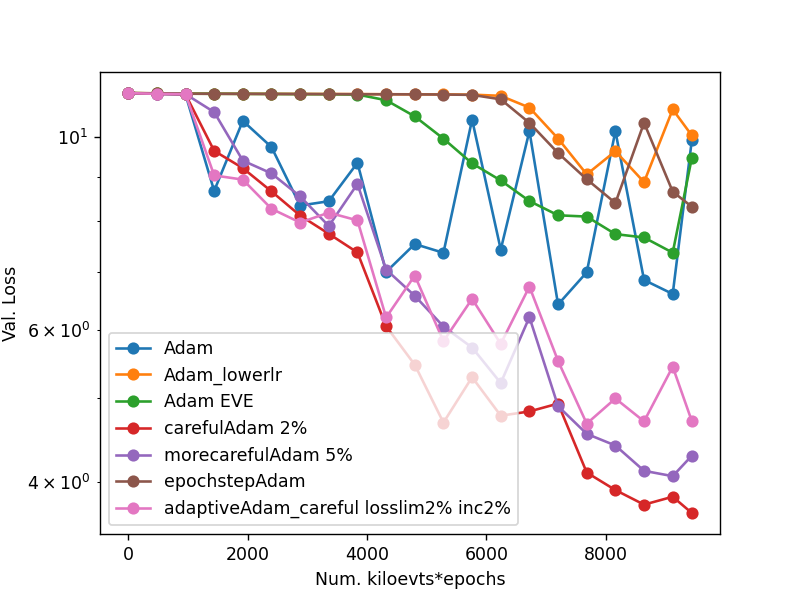

In [10]:
plt.figure()
for i in range(len(dict_paths)):
    scan_size = scan_sizes[all_runs[run_labels[i]][0]]
    if np.arange(0, num_epochs[i], scan_size)[-1] != (num_epochs[i]-1):
        plt.plot(np.append(np.arange(0, num_epochs[i], scan_size), [num_epochs[i]-1]), eval_losses[i], 'o-', label=run_labels[i])
    else:
        plt.plot(np.arange(0, num_epochs[i], scan_size), eval_losses[i], 'o-', label=run_labels[i])
plt.xlabel("Epoch")
plt.ylabel("Val. Loss")
plt.yscale('log')
plt.legend()

#now approx. normalizing x axis for comp time
plt.figure()
for i in range(len(dict_paths)):
    num_evts = all_runs[run_labels[i]][0]
    scan_size = scan_sizes[all_runs[run_labels[i]][0]] 
    #print(scan_size)
    if np.arange(0, num_epochs[i], scan_size)[-1] != num_epochs[i]-1:
        plt.plot(num_evts*np.append(np.arange(0, num_epochs[i], scan_size), [num_epochs[i]-1]), eval_losses[i], 'o-', label=run_labels[i])
    else:
        plt.plot(num_evts*np.arange(0, num_epochs[i], scan_size), eval_losses[i], 'o-', label=run_labels[i])
plt.xlabel("Num. kiloevts*epochs")
plt.ylabel("Val. Loss")
plt.yscale('log')
plt.legend()